<a href="https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/transition-matrix-gee-glance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install geemap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [35]:
# Import libraries
import pandas as pd
import ee
import os
import sys
import geemap


# Define repository details
repo_url = 'https://github.com/antoniovfonseca/agentic-ai-global-lulc.git'
repo_name = 'agentic-ai-global-lulc'

# Clone or update the repository
if not os.path.exists(repo_name):
    print(f"Cloning {repo_name}...")
    !git clone {repo_url}
else:
    print(f"Updating {repo_name}...")
    !cd {repo_name} && git pull

# Add the notebooks directory to system path to allow imports
notebooks_path = os.path.join(repo_name, 'notebooks')
if notebooks_path not in sys.path:
    sys.path.append(os.path.abspath(notebooks_path))
    print(f"Added {notebooks_path} to system path.")

import importlib
import utils

importlib.reload(utils)
print("Utils module loaded successfully.")

Updating agentic-ai-global-lulc...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.75 KiB | 299.00 KiB/s, done.
From https://github.com/antoniovfonseca/agentic-ai-global-lulc
   8f6a6cf..cdba1cb  main       -> origin/main
Updating 8f6a6cf..cdba1cb
Fast-forward
 notebooks/utils.py | 98 +++++++++++++++++++++---------------------------------
 1 file changed, 38 insertions(+), 60 deletions(-)
Added agentic-ai-global-lulc/notebooks to system path.
Utils module loaded successfully.


In [16]:
import ee
import geemap
import pandas as pd
import utils  # Certifique-se que o utils.py está na mesma pasta ou no sys.path

# Autenticação e Inicialização
try:
    ee.Initialize(project='ee-antoniovicgf')
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='ee-antoniovicgf')

In [11]:
# 1. Define the full range of years (2001 to 2019)
# This will result in 18 annual transitions + 1 long-term transition
years_to_process = list(range(2001, 2020))

# 2. Trigger the export tasks via the updated utils function
# Scale=30 ensures native resolution; drive_folder is where CSVs will appear
tasks_list = utils.export_global_transition_tasks(
    year_list=years_to_process,
    drive_folder="GLANCE_Global_Transitions_30m",
    scale=30
)

# 3. Quick overview of the triggered tasks
print(f"\nSuccessfully triggered {len(tasks_list)} export tasks.")
print("You can monitor progress in the GEE Tasks tab or via code.")

Task started for transition_2001_2002 (Scale: 30m)
Task started for transition_2002_2003 (Scale: 30m)
Task started for transition_2003_2004 (Scale: 30m)
Task started for transition_2004_2005 (Scale: 30m)
Task started for transition_2005_2006 (Scale: 30m)
Task started for transition_2006_2007 (Scale: 30m)
Task started for transition_2007_2008 (Scale: 30m)
Task started for transition_2008_2009 (Scale: 30m)
Task started for transition_2009_2010 (Scale: 30m)
Task started for transition_2010_2011 (Scale: 30m)
Task started for transition_2011_2012 (Scale: 30m)
Task started for transition_2012_2013 (Scale: 30m)
Task started for transition_2013_2014 (Scale: 30m)
Task started for transition_2014_2015 (Scale: 30m)
Task started for transition_2015_2016 (Scale: 30m)
Task started for transition_2016_2017 (Scale: 30m)
Task started for transition_2017_2018 (Scale: 30m)
Task started for transition_2018_2019 (Scale: 30m)
Task started for transition_2001_2019 (Scale: 30m)

Successfully triggered 19 expo

In [ ]:
# Optional cell to monitor the status of the tasks
for task in tasks_list:
    status = task.status()
    print(f"Task: {status['description']} | Status: {status['state']}")

Task: transition_2001_2002 | Status: COMPLETED
Task: transition_2002_2003 | Status: COMPLETED
Task: transition_2003_2004 | Status: COMPLETED
Task: transition_2004_2005 | Status: COMPLETED
Task: transition_2005_2006 | Status: COMPLETED
Task: transition_2006_2007 | Status: COMPLETED
Task: transition_2007_2008 | Status: COMPLETED
Task: transition_2008_2009 | Status: COMPLETED
Task: transition_2009_2010 | Status: COMPLETED
Task: transition_2010_2011 | Status: FAILED
Task: transition_2011_2012 | Status: COMPLETED
Task: transition_2012_2013 | Status: COMPLETED
Task: transition_2013_2014 | Status: COMPLETED
Task: transition_2014_2015 | Status: COMPLETED
Task: transition_2015_2016 | Status: COMPLETED
Task: transition_2016_2017 | Status: COMPLETED
Task: transition_2017_2018 | Status: COMPLETED
Task: transition_2018_2019 | Status: COMPLETED
Task: transition_2001_2019 | Status: COMPLETED


In [ ]:
import time
from tqdm.notebook import tqdm

# 1. Initialize the progress bar with the total number of tasks
pbar = tqdm(total=len(tasks_list), desc="Exporting GLANCE Matrices")

# 2. Track which tasks have already been counted as finished
completed_task_ids = set()

# 3. Monitor loop: runs until all tasks are COMPLETED or FAILED
while len(completed_task_ids) < len(tasks_list):
    for task in tasks_list:
        # 4. Skip if the task was already processed in previous iterations
        if task.id in completed_task_ids:
            continue

        # 5. Check current status from GEE server
        status = task.status()
        state = status['state']

        # 6. Update progress bar if task reaches a terminal state
        if state in ['COMPLETED', 'FAILED', 'CANCELLED']:
            completed_task_ids.add(task.id)
            pbar.update(1)

            if state == 'FAILED':
                print(f"\nTask {status['description']} failed: {status.get('error_message')}")

    # 7. Wait 30 seconds before polling the server again to avoid overhead
    if len(completed_task_ids) < len(tasks_list):
        time.sleep(30)

pbar.close()
print("All export tasks have been processed.")

Exporting GLANCE Matrices:   0%|          | 0/19 [00:00<?, ?it/s]


Task transition_2010_2011 failed: Computation timed out.


All export tasks have been processed.


In [12]:
# 1. Mount Google Drive to access the files
from google.colab import drive
drive.mount('/content/drive')

# 2. Define the path where the CSVs were saved
# Adjust this path according to your Drive structure
path_to_csvs = "/content/drive/MyDrive/GLANCE_Global_Transitions_30m"

# 3. Load and convert all files into transition matrices
matrices_dict = utils.load_global_transition_matrices(
    drive_path=path_to_csvs
)

# 4. Access any specific matrix (e.g., the long-term one)
display(matrices_dict["2001_2019"])

Mounted at /content/drive


To,Barren,Developed,Herbaceous,Ice/Snow,Shrub,Trees,Water
From,,,,,,,
Barren,4617781024,1372738,143825256,66309,225385078,19187688,11943288
Developed,1273519,878443767,16370403,1238,2556607,2987554,355686
Herbaceous,117850415,43780963,36671595178,29008,636418755,1313266252,65037940
Ice/Snow,126481,484,19992,6548068404,2559,59447,27013
Shrub,54030152,2171602,889707143,14663,8488427463,469446939,2961913
Trees,13485698,16820397,1731886691,56686,507533337,33404868559,20693272
Water,32701720,646883,71946482,39158,3352176,15062043,18760485145


In [6]:
# 1. Convert pixel matrices to area matrices (km2)
# Using the dictionary 'matrices_dict' loaded in the previous step
area_results = utils.convert_matrices_to_area(
    matrices_dict=matrices_dict,
    pixel_size=30
)

# 2. Display the long-term transition in km2
print("Global Transition Matrix 2001-2019 (Values in km²):")
display(area_results["2001_2019"])

NameError: name 'matrices_dict' is not defined

In [36]:
# 1. Define the destination folder in your mounted Google Drive
# Replace this path with your preferred Drive directory
drive_output_path = "/content/drive/MyDrive/GLANCE_Global_Transitions_30m/results_km2"

# 2. Call the utility function to export all matrices
# This will save all 19 matrices (18 annual + 1 long-term)
exported_files = utils.save_area_matrices_to_csv(
    area_matrices=area_results,
    output_dir=drive_output_path
)

# 3. Final summary of the operation
print(f"\nOperation complete: {len(exported_files)} matrices are now in your Drive.")

NameError: name 'area_results' is not defined

In [37]:
# Caminho onde estão suas matrizes anuais de km2
input_folder = "/content/drive/MyDrive/GLANCE_Global_Transitions_30m/results_km2"

# Nome do arquivo SUM que o código de heatmap espera (com hífen YYYY-YYYY)
output_file = os.path.join(input_folder, "transition_matrix_sum_2001-2019.csv")

# Executar a soma
df_total_sum = utils.compute_sum_matrix(
    input_dir=input_folder,
    output_path=output_file
)

SUM matrix successfully saved to: /content/drive/MyDrive/GLANCE_Global_Transitions_30m/results_km2/transition_matrix_sum_2001-2019.csv


In [38]:
# 1. Define paths for the base matrices
input_dir = "/content/drive/MyDrive/GLANCE_Global_Transitions_30m/results_km2"
path_sum = os.path.join(
    input_dir,
    "transition_matrix_sum_2001-2019.csv",
)
path_ext = os.path.join(
    input_dir,
    "transition_matrix_km2_2001_2019.csv",
)

# 2. Load the base dataframes
# Note: df_ext is your transition_matrix_km2_2001_2019.csv
df_sum_base = pd.read_csv(
    path_sum,
    index_col=0,
)
df_ext_base = pd.read_csv(
    path_ext,
    index_col=0,
)

# 3. Execute the decomposition and save all 6 required components
# This prepares the files for the heatmap cells (Cell 1, 2, 3)
utils.compute_and_save_components(
    df_sum=df_sum_base,
    df_ext=df_ext_base,
    output_dir=input_dir,
    period_label="2001-2019",
)

Component saved: transition_matrix_sum_2001-2019.csv
Component saved: transition_matrix_extent_2001-2019.csv
Component saved: transition_matrix_allocation_exchange_2001-2019.csv
Component saved: transition_matrix_allocation_shift_2001-2019.csv
Component saved: transition_matrix_alternation_exchange_2001-2019.csv
Component saved: transition_matrix_alternation_shift_2001-2019.csv


In [39]:
# 1. Period Setup from your specific variable
y_start = years_to_process[0]
y_end = years_to_process[-1]
period_str = f"{y_start}-{y_end}"

# Directory where your km2 matrices are stored
input_dir = "/content/drive/MyDrive/GLANCE_Global_Transitions_30m/results_km2"

# 2. List of component names to load
component_names = [
    "sum",
    "extent",
    "allocation_exchange",
    "allocation_shift",
    "alternation_exchange",
    "alternation_shift"
]

# 3. Bulk Loading into a dictionary
raw_matrices = {}
for name in component_names:
    # Note: Use hyphen as expected by the files saved in the previous step
    file_path = os.path.join(input_dir, f"transition_matrix_{name}_{period_str}.csv")
    raw_matrices[name] = pd.read_csv(file_path, index_col=0)

# 4. Reordering using your utils function
ordered_results = utils.reorder_matrices_by_net_change(
    df_sum=raw_matrices["sum"],
    df_ext=raw_matrices["extent"],
    df_ext_exc=raw_matrices["allocation_exchange"],
    df_ext_shift=raw_matrices["allocation_shift"],
    df_alt_exc=raw_matrices["alternation_exchange"],
    df_alt_shift=raw_matrices["alternation_shift"]
)

# 5. Map the ordered results back to a dictionary
ordered_matrices = dict(zip(component_names, ordered_results))

print(f"Successfully loaded and reordered {len(ordered_matrices)} matrices for {period_str}.")

Successfully loaded and reordered 6 matrices for 2001-2019.


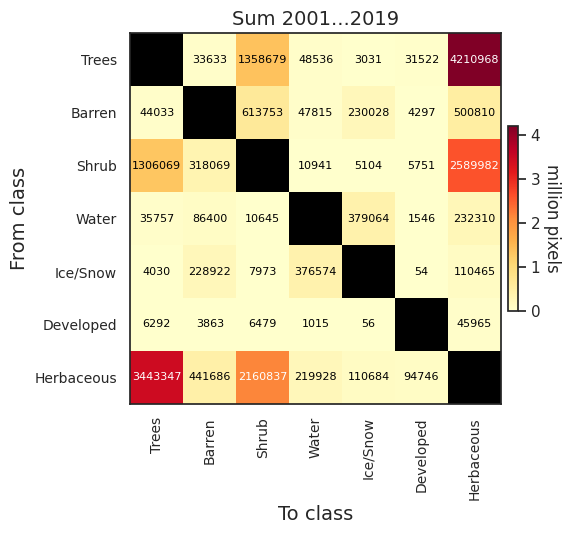

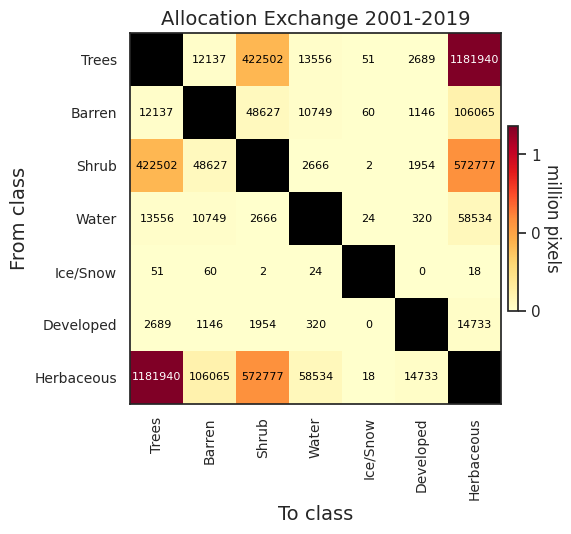

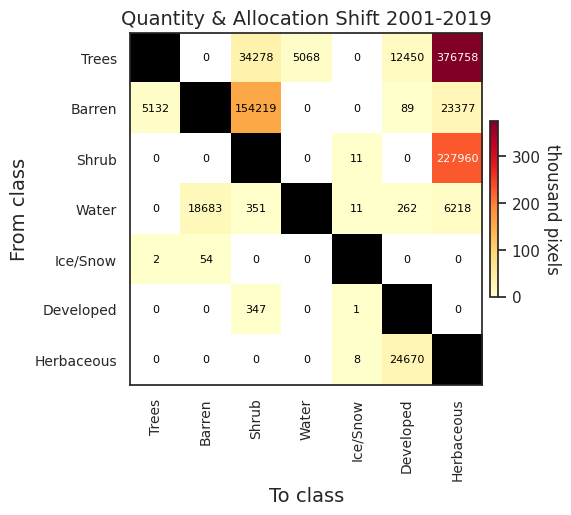

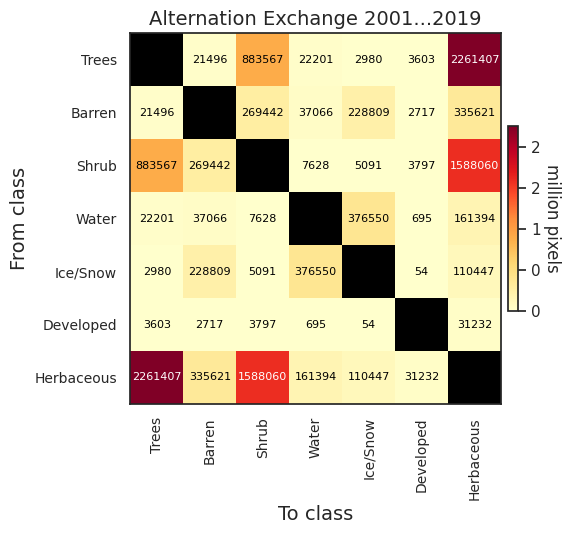

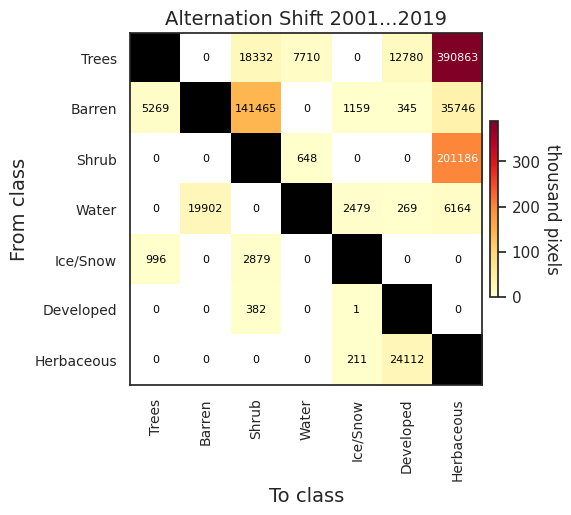

All 5 heatmaps generated and saved in /content/drive/MyDrive/GLANCE_Global_Transitions_30m/results_km2


In [40]:
# 1. Period and path setup from your variables
y_start = years_to_process[0]
y_end = years_to_process[-1]
period_str = f"{y_start}-{y_end}"

# 2. Configuration mapping for the 5 scientific components
# Each entry defines: (matrix_key, plot_title, filename)
plots_metadata = [
    ("sum", f"Sum {y_start}...{y_end}", "sum"),
    ("allocation_exchange", f"Allocation Exchange {period_str}", "allocation_exchange"),
    ("allocation_shift", f"Quantity & Allocation Shift {period_str}", "allocation_shift"),
    ("alternation_exchange", f"Alternation Exchange {y_start}...{y_end}", "alternation_exchange"),
    ("alternation_shift", f"Alternation Shift {y_start}...{y_end}", "alternation_shift")
]

# 3. Execution loop to generate identical heatmaps
for key, title, file_suffix in plots_metadata:
    if key in ordered_matrices:
        # Define the full save path
        save_path = os.path.join(
            input_dir,
            f"heatmap_{file_suffix}_{period_str}.png"
        )

        # Calling the identical reference function from utils
        # Note: cbar_label is the base string used by _unit_label
        utils.plot_heatmap(
            df=ordered_matrices[key],
            title=title,
            class_labels_dict=utils.GLANCE_METADATA,  # Adicionado para mapear IDs para nomes
            save_path=save_path,
            tick_fontsize_x=10,
            tick_fontsize_y=10,
            axis_label_fontsize=14,
            title_fontsize=14,
            ann_fontsize=8,
            cbar_label="Area (km²)",
            cbar_fraction=0.025,  # Valor exato da sua referência
            cbar_pad=0.02,        # Valor exato da sua referência
            rotate_xticks_deg=90
        )

print(f"All {len(plots_metadata)} heatmaps generated and saved in {input_dir}")